In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import pickle

import tensorflow as tf

import os

In [2]:
print(tf.version.VERSION)

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

2.8.0


In [3]:
gpus = tf.config.list_physical_devices('GPU')

print(gpus)
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
with open('../data/var1.pkl', 'rb') as file:
    train_data, test_data, e_params, t_params, ft_params = pickle.load(file)

In [5]:
# операция обратная стандартизации для восстановления результата
def restore_result(e_vals):
    return e_vals * e_params[1] + e_params[0]

# Dataset

In [6]:
def split_time_series(series, input_width, label_width,
                         step, input_columns, label_columns):
    
    window_size = input_width + label_width
    
    res_len = (len(series) - window_size) // step + 1
    
    x = np.zeros((res_len, input_width, len(input_columns)))
    y = np.zeros((res_len, label_width, len(label_columns)))
    
    for i in range(res_len):
        x[i] = series[i * step: i * step + input_width, input_columns]
        y[i] = series[i * step + input_width : 
                      i * step + window_size, label_columns]
        
    return x, y

In [7]:
'''
def create_dataset(train_series, test_series, 
                   input_width, label_width, step,
                   input_columns, label_columns):
    
    x_train, y_train = split_time_series(train_series, 
                                         input_width, label_width,
                                         step, input_columns, label_columns)
    
    total_series = np.concatenate([train_series, test_series])
    total_series = total_series[len(train_series) - (input_width + label_width) + step :]
    
    x_test, y_test = split_time_series(total_series, 
                                         input_width, label_width,
                                         step, input_columns, label_columns)
    
    return x_train, y_train, x_test, y_test
'''

print()

In [22]:
INPUT_WIDTH = 30 * 6
LABEL_WIDTH = 30
STEP = 1

INPUT_COLUMNS = [0, 1, 2, 3, 8, 9, 10, 11, 12, 13]
LABEL_COLUMNS = [0, 1]

In [23]:
'''
x_train, y_train, x_test, y_test = create_dataset(train_data.to_numpy(), test_data.to_numpy(), 
                                                     INPUT_WIDTH, LABEL_WIDTH, STEP,
                                                     INPUT_COLUMNS, LABEL_COLUMNS)
'''

x_train, y_train = split_time_series(train_data.to_numpy(),
                                     INPUT_WIDTH, LABEL_WIDTH,
                                     STEP, INPUT_COLUMNS, LABEL_COLUMNS)
x_test, y_test = split_time_series(test_data.to_numpy(),
                                     INPUT_WIDTH, LABEL_WIDTH,
                                     STEP, INPUT_COLUMNS, LABEL_COLUMNS)

print(x_train.shape, y_train.shape, '\n', x_test.shape, y_test.shape)

(1617, 180, 10) (1617, 30, 2) 
 (156, 180, 10) (156, 30, 2)


# Model

In [24]:
tf.keras.utils.set_random_seed(10)

BATCH_SIZE = 1
MAX_EPOCHS = 1000

In [25]:
def build_model():
    
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(units=16, activation='tanh'),
        
        tf.keras.layers.Dense(units=LABEL_WIDTH * len(LABEL_COLUMNS)),
        
        tf.keras.layers.Reshape([LABEL_WIDTH, len(LABEL_COLUMNS)])
    ])
    
    model.build(input_shape=(BATCH_SIZE, INPUT_WIDTH, len(INPUT_COLUMNS)))
    
    model.compile(optimizer='adam', loss='mse', )
    
    return model

In [26]:
model = build_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (1, 1800)                 0         
                                                                 
 dense_4 (Dense)             (1, 16)                   28816     
                                                                 
 dense_5 (Dense)             (1, 60)                   1020      
                                                                 
 reshape_2 (Reshape)         (1, 30, 2)                0         
                                                                 
Total params: 29,836
Trainable params: 29,836
Non-trainable params: 0
_________________________________________________________________


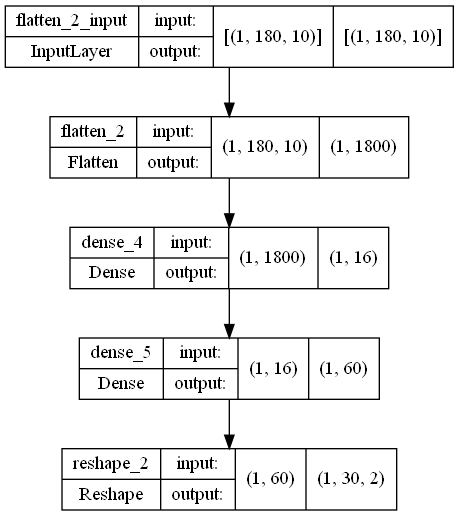

In [27]:
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
log_dir = "./logs"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [29]:
checkpoint_name = "../models/mlp/02/checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_name)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath = checkpoint_name, 
                    verbose = 1, 
                    save_weights_only = True,
                    save_freq = 10 * len(x_train))

In [30]:
# latest = tf.train.latest_checkpoint(checkpoint_dir)

# model.load_weights(latest)

In [ ]:
model.fit(x_train, y_train, 
          validation_data = (x_test, y_test),
          batch_size = BATCH_SIZE, 
          epochs = MAX_EPOCHS, 
          callbacks = [tensorboard_callback, cp_callback])

Epoch 1/1000
1617/1617 [==============================] - 20s 13ms/step - loss: 0.2507 - val_loss: 0.1397
Epoch 2/1000
1617/1617 [==============================] - 20s 12ms/step - loss: 0.2004 - val_loss: 0.1497
Epoch 3/1000
1617/1617 [==============================] - 20s 12ms/step - loss: 0.1777 - val_loss: 0.1246
Epoch 4/1000
1617/1617 [==============================] - 20s 12ms/step - loss: 0.1725 - val_loss: 0.1278
Epoch 5/1000
1617/1617 [==============================] - 20s 12ms/step - loss: 0.1674 - val_loss: 0.1390
Epoch 6/1000
1617/1617 [==============================] - 20s 12ms/step - loss: 0.1617 - val_loss: 0.1355
Epoch 7/1000
1617/1617 [==============================] - 20s 12ms/step - loss: 0.1588 - val_loss: 0.1652
Epoch 8/1000
1617/1617 [==============================] - 20s 13ms/step - loss: 0.1551 - val_loss: 0.1521
Epoch 9/1000
1617/1617 [==============================] - 20s 13ms/step - loss: 0.1525 - val_loss: 0.1491
Epoch 10/1000
1613/1617 [=====================

In [20]:
from matplotlib import pyplot as plt

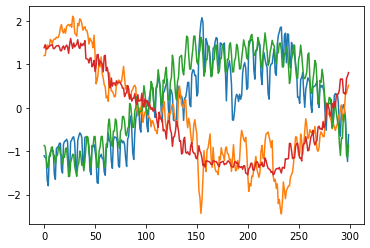

In [21]:
plt.plot(np.squeeze(y_train[:300])[:, 0])
plt.plot(np.squeeze(model(x_train[:300]))[:, 0])

plt.show()

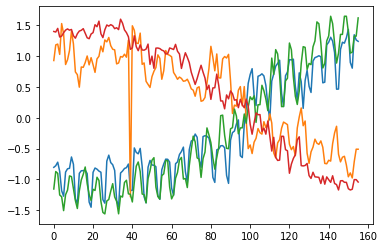

In [22]:
plt.plot(np.squeeze(y_test[:300])[:, 0])
plt.plot(np.squeeze(model(x_test[:300]))[:, 0])

plt.show()

# Evaluate

In [ ]:
%run evaluate_forecasts.ipynb

evaluate_forecasts(test.to_numpy(), [predicted], ['SNAIVE'])